# kaggleで遊ぼう

## 今回のお題：[kaggle - Shelter Animal Outcomes](https://www.kaggle.com/c/shelter-animal-outcomes)

# ４つの基本ステップ

1. 準備（データを落として来たり、ライブラリを読み込んだりする）
2. データ整形（予測に効きそうな特徴量をうまくデザインしながら、全ての情報を数値データに変換する）
3. 機械学習（交差検定を駆使してモデルごとに程よいハイパーパラメータを選び、最後にアンサンブル学習）
4. 結果提出（予測結果をCSVファイルに書き出して、kaggleに提出）

# ステップ１：準備

目的：データを用意し、ライブラリを読み込む

In [1]:
# ディレクトリ構成を揃える（input, output, code）
#!ls -la ..

In [2]:
# データ整形と可視化で必要となるライブラリを読み込む

# 数値計算用ライブラリ
import numpy as np  

# データ解析用ライブラリ
import pandas as pd  

# 基本の描画ライブラリ（２つ）
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 便利な設定

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

# ステップ２：データ整形

目的：データの特徴を理解し、機械学習ができる形に整形する

## データを読み込む

- `pd.read_csv()`を使うと良い

In [4]:
# データの読み込み
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
df_sub = pd.read_csv("../input/sample_submission.csv")

## データを眺める

#### データを眺めるときに使える関数
- `df.head()`, `df.tail()`
- `df.info()`
- `df.describe()`

In [5]:
df_train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [7]:
df_test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 8 columns):
ID                11456 non-null int64
Name              8231 non-null object
DateTime          11456 non-null object
AnimalType        11456 non-null object
SexuponOutcome    11456 non-null object
AgeuponOutcome    11450 non-null object
Breed             11456 non-null object
Color             11456 non-null object
dtypes: int64(1), object(7)
memory usage: 716.1+ KB


In [9]:
df_train.shape

(26729, 10)

In [10]:
df_test.shape

(11456, 8)

'OutcomeType' と 'OutcomeSubtype' が予測対象となるラベルっぽいことがわかる。

In [11]:
df_train.describe(include='all')

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


'OutcomeType'が最終的に予測するラベルで、OutcomeSubtypeは予測を助けるための補助変数っぽいことがわかる。
とりあえず、しばらくは'OutcomeType'を直接求める方針で。

In [12]:
df_test.describe(include='all')

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,11456.000000,8231,11456,11456,11456,11450,11456,11456
unique,NaN,3712,10575,2,5,45,913,277
top,NaN,Bella,2014-10-20 09:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,NaN,60,8,6656,4235,1768,3777,1219
mean,5728.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3307.206676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2864.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5728.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8592.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [14]:
df_test.dtypes

ID                 int64
Name              object
DateTime          object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

## データの結合

- 整形のため（特に欠損値を埋めるため）、トレーニングデータとテストデータを合わせる
- 注：本来であればトレーニングデータで得た知見だけを使い、トレーニングデータとテストデータの欠損値を埋めるべきだが、簡単のため今回はこうする

In [15]:
# 一応、AnimalIDとIDがユニークな値であることを確認
print len(df_train)
print len(df_train['AnimalID'].unique())

print len(df_test)
print len(df_test['ID'].unique())

26729
26729
11456
11456


In [16]:
# テストデータとの整合性を保つため、トレーニングデータのAnimalIDというカラム名をIDに変更する
df_train.rename(columns={'AnimalID': 'ID'}, inplace=True)

In [17]:
# IDというカラムをインデックスとする
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

In [18]:
# 後でデータを分離しやすいよう、結合前にトレーニングデータとテストデータがわかるようなラベルを振っておく
df_train['_data'] = 'train'
df_test['_data'] = 'test'

In [19]:
# データセットを結合する
df = pd.concat([df_train, df_test], axis=0)

In [20]:
# 一応、データの形をチェック
print df.shape
print df_train.shape
print df_test.shape

(38185, 10)
(26729, 10)
(11456, 8)


## 出力特徴量（従属変数）の整形

In [21]:
# 欠損値に関する情報を得る
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 10 columns):
AgeuponOutcome    38161 non-null object
AnimalType        38185 non-null object
Breed             38185 non-null object
Color             38185 non-null object
DateTime          38185 non-null object
Name              27269 non-null object
OutcomeSubtype    13117 non-null object
OutcomeType       26729 non-null object
SexuponOutcome    38184 non-null object
_data             38185 non-null object
dtypes: object(10)
memory usage: 3.2+ MB


In [22]:
df_sub.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


In [23]:
outcome_labels = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
outcome2id = dict(zip(*[outcome_labels, np.arange(5)]))
outcome2id

{'Adoption': 0,
 'Died': 1,
 'Euthanasia': 2,
 'Return_to_owner': 3,
 'Transfer': 4}

In [24]:
# zip()の使用例
zip(*[['a', 'b'], [1, 2]])

[('a', 1), ('b', 2)]

In [25]:
# 最終的に予測するターゲット
df['OutcomeTypeId'] = df['OutcomeType'].map(outcome2id)

In [26]:
# 使わない変数はこのリストに保持
# 後で、df.drop(not_needed, axis=1, inplace=True) とすることで、いらない列を落とせる。
# 予測に使用する変数が増えて来たときに活躍する。
# 今回は簡単のため、OutcomeSubtypeは無視する。
not_needed = ['OutcomeType', 'OutcomeSubtype']

## 入力特徴量（独立変数）の整形

In [27]:
df.head()

,AgeuponOutcome,AnimalType,Breed,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,_data,OutcomeTypeId
ID,,,,,,,,,,,
A671945,1 year,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,train,3.0
A656520,1 year,Cat,Domestic Shorthair Mix,Cream Tabby,2013-10-13 12:44:00,Emily,Suffering,Euthanasia,Spayed Female,train,2.0
A686464,2 years,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,Pearce,Foster,Adoption,Neutered Male,train,0.0
A683430,3 weeks,Cat,Domestic Shorthair Mix,Blue Cream,2014-07-11 19:09:00,NaN,Partner,Transfer,Intact Male,train,4.0
A667013,2 years,Dog,Lhasa Apso/Miniature Poodle,Tan,2013-11-15 12:52:00,NaN,Partner,Transfer,Neutered Male,train,4.0


### AgeuponOutcome

In [28]:
c = 'AgeuponOutcome'

# 欠損値について調べる
df[[c]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 1 columns):
AgeuponOutcome    38161 non-null object
dtypes: object(1)
memory usage: 596.6+ KB


In [29]:
cf = 'AgeuponOutcomeFill'

# 最も頻度の高い値で埋めてみる
most_freq_value = df[c].value_counts().index[0]
df[cf] = df[c].fillna(most_freq_value)
not_needed.append(c)

In [30]:
#　異常値の取り扱い
print np.sum(df[cf] == '0 years')
df.ix[df[cf] == '0 years', cf] = '6 months'
print np.sum(df[cf] == '0 years')

35
0


In [31]:
conv2day = {}
conv2day['day'] = 1
conv2day['week'] = 7
conv2day['month'] = 30
conv2day['year'] = 365

In [32]:
age_list = df[cf].unique()

In [33]:
age_in_day = [int(a.split(" ")[0]) * conv2day[a.split(" ")[1].rstrip("s")] for a in age_list]

In [34]:
age2day = dict(zip(age_list, age_in_day))

In [35]:
df['DayuponOutcome'] =  [age2day[a] for a in df[cf]]

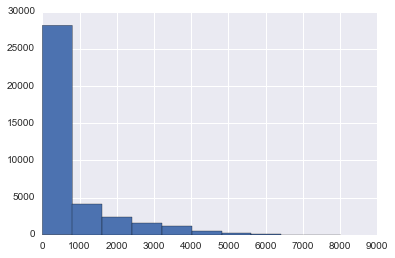

In [36]:
df['DayuponOutcome'].hist()

In [37]:
df['LogDayuponOutcome'] =  [np.log(age2day[a]) for a in df[cf]]

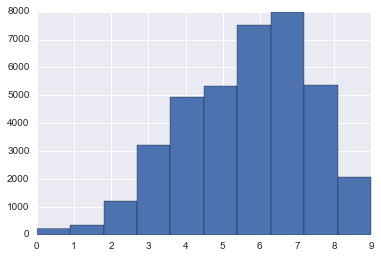

In [38]:
df['LogDayuponOutcome'].hist()

In [39]:
not_needed.extend([cf])

### AnimalType

In [40]:
# 生データを眺める
df['AnimalType']

ID
A671945    Dog
A656520    Cat
A686464    Dog
A683430    Cat
A667013    Dog
A677334    Dog
A699218    Cat
A701489    Cat
A671784    Dog
A677747    Dog
A668402    Cat
A666320    Dog
A684601    Dog
A704702    Dog
A688584    Dog
A678825    Cat
A678050    Cat
A680028    Dog
A679010    Cat
A684787    Dog
A670658    Dog
A708812    Cat
A705262    Dog
A665781    Dog
A676333    Dog
A712750    Cat
A718832    Dog
A698777    Dog
A715348    Cat
A708666    Cat
          ... 
11427      Dog
11428      Dog
11429      Dog
11430      Dog
11431      Cat
11432      Cat
11433      Dog
11434      Cat
11435      Dog
11436      Cat
11437      Cat
11438      Dog
11439      Dog
11440      Dog
11441      Cat
11442      Dog
11443      Dog
11444      Cat
11445      Cat
11446      Cat
11447      Cat
11448      Dog
11449      Dog
11450      Dog
11451      Dog
11452      Cat
11453      Cat
11454      Cat
11455      Dog
11456      Dog
Name: AnimalType, dtype: object

In [41]:
# 欠損値に関する情報を得る
df[['AnimalType']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 1 columns):
AnimalType    38185 non-null object
dtypes: object(1)
memory usage: 596.6+ KB


In [42]:
# 犬と猫の数を調べる
df['AnimalType'].value_counts()

Dog    22251
Cat    15934
Name: AnimalType, dtype: int64

In [43]:
# 犬と猫でどう違うのか見る
pt = df.pivot_table(values='_data', columns='OutcomeType', index='AnimalType', aggfunc=lambda x: len(x))
pt = pt.T
pt

AnimalType,Cat,Dog
OutcomeType,,
Adoption,4272,6497
Died,147,50
Euthanasia,710,845
Return_to_owner,500,4286
Transfer,5505,3917


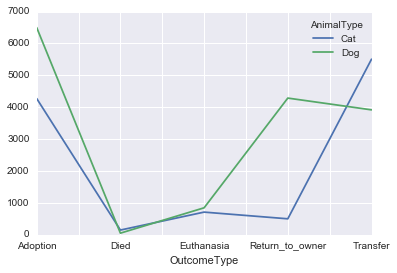

In [44]:
# 　描画
pt.plot()

In [45]:
# 猫と犬、それぞれにおけるターゲットの割合を計算
pt2 = pt / pt.sum()
pt2

AnimalType,Cat,Dog
OutcomeType,,
Adoption,0.383690,0.416608
Died,0.013203,0.003206
Euthanasia,0.063769,0.054184
Return_to_owner,0.044907,0.274832
Transfer,0.494431,0.251170


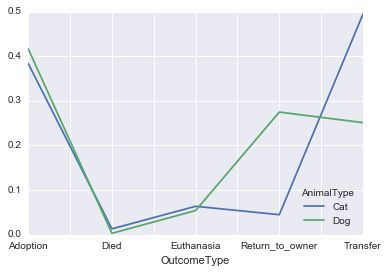

In [46]:
pt2.plot()

In [47]:
pt2

AnimalType,Cat,Dog
OutcomeType,,
Adoption,0.383690,0.416608
Died,0.013203,0.003206
Euthanasia,0.063769,0.054184
Return_to_owner,0.044907,0.274832
Transfer,0.494431,0.251170


In [48]:
animal_type2id = {'Dog': 0, 'Cat': 1}
df['AnimalTypeId'] = df['AnimalType'].map(animal_type2id)
not_needed.append('AnimalType')

### Breed

In [56]:
df['BreedCount'] = df['Breed'].map(df['Breed'].value_counts())

In [57]:
df['LogBreedCount'] = np.log(df['BreedCount'])

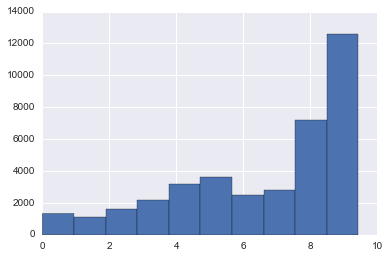

In [58]:
df['LogBreedCount'].hist()

In [59]:
not_needed.append('Breed')

### Color

In [60]:
df[['Color']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 1 columns):
Color    38185 non-null object
dtypes: object(1)
memory usage: 596.6+ KB


In [61]:
df['ColorCount'] = df['Color'].map(df['Color'].value_counts())

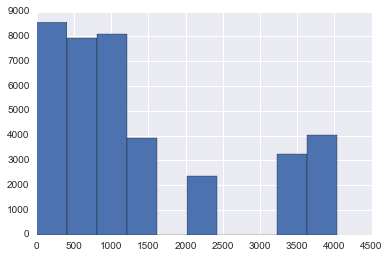

In [62]:
df['ColorCount'].hist()

In [63]:
df['LogColorCount'] = np.log(df['ColorCount'])

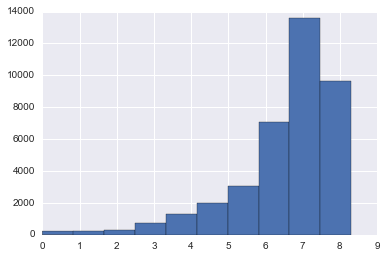

In [64]:
df['LogColorCount'].hist()

In [65]:
not_needed.append('Color')

### DateTime

In [66]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [67]:

df['DateTime_year'] = df['DateTime'].dt.year
#df['DateTime_month'] = df['DateTime'].dt.month
df['DateTime_day'] = df['DateTime'].dt.day
df['DateTime_dayofweek'] = df['DateTime'].dt.dayofweek
df['DateTime_hour'] = df['DateTime'].dt.hour
df['DateTime_minute'] = df['DateTime'].dt.minute
df['DateTime_dayofyear'] = df['DateTime'].dt.dayofyear
df['DateTime_weekofyear'] = df['DateTime'].dt.weekofyear
#df['DateTime_weekend'] = (df['DateTime'].dt.dayofweek >= 5).astype(int)

In [68]:
not_needed.append('DateTime')

### Name

In [69]:
# 欠損値について調べる
df[['Name']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 1 columns):
Name    27269 non-null object
dtypes: object(1)
memory usage: 596.6+ KB


In [70]:
# 「名前が無い」ということは重要な特徴かもしれない
df['NameIsNull'] = df['Name'].isnull()

In [71]:
df['Name'].value_counts()

Bella          195
Max            174
Charlie        163
Daisy          148
Lucy           128
Princess       128
Rocky          125
Buddy          111
Luna           108
Jack            96
Lola            88
Coco            88
Sadie           83
Molly           82
Lucky           78
Blue            77
Shadow          75
Oreo            74
Lily            74
Toby            71
Maggie          69
Chico           67
Duke            65
Cookie          65
Ginger          63
Milo            63
Leo             63
Sophie          63
Lady            61
Marley          60
              ... 
Q-Tip            1
Minx             1
Miny             1
Nikola           1
Hilton           1
Lady Sasha       1
Direwolf         1
Danika           1
Bossco           1
Hook             1
Selsa            1
Cleveland        1
Heine            1
Shaina           1
Ellis            1
Lady Grey        1
Tyke             1
Allister         1
Quorra           1
Jenny Tyson      1
Yeshua           1
Jillaroo    

In [72]:
df['NameCount'] = df['Name'].map(df['Name'].value_counts())
df['NameCount'] = df['NameCount'].fillna(1)

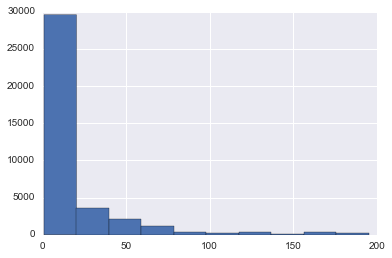

In [73]:
df['NameCount'].hist()

In [74]:
# 対数変換した名前カウント
df['LogNameCount'] = np.log(df['NameCount'])

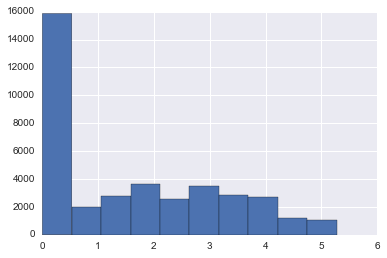

In [75]:
df['LogNameCount'].hist()

In [76]:
# 名前の文字数。名前が無い場合は0とした。
df['NameLength'] = df['Name'].fillna('').apply(lambda x: len(x))

In [77]:
# 名前と名前の文字数が一致しているか確認
df[['Name', 'NameLength']].head(10)

,Name,NameLength
ID,,
A671945,Hambone,7
A656520,Emily,5
A686464,Pearce,6
A683430,NaN,0
A667013,NaN,0
A677334,Elsa,4
A699218,Jimmy,5
A701489,NaN,0
A671784,Lucy,4


In [78]:
not_needed.append('Name')

### SexuponOutcome

In [79]:
# 欠損値の情報
df[['SexuponOutcome']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 38185 entries, A671945 to 11456
Data columns (total 1 columns):
SexuponOutcome    38184 non-null object
dtypes: object(1)
memory usage: 596.6+ KB


In [80]:
# 1個だけ欠損値があるので、一番多いクラスラベルで埋めることにする
most_popular = df['SexuponOutcome'].value_counts().index[0]
df['SexuponOutcomeFill'] = df['SexuponOutcome'].fillna(most_popular)
not_needed.append('SexuponOutcome')

In [81]:
df['SexuponOutcomeFill'].value_counts()

Neutered Male    14015
Spayed Female    12633
Intact Female     5004
Intact Male       4985
Unknown           1548
Name: SexuponOutcomeFill, dtype: int64

In [82]:
# ワンホットコーディング

# dfから'SexuponOutcomeをワンホットコーディングと入れ替え
#df = pd.get_dummies(df, columns=['SexuponOutcome'])  

_df = pd.get_dummies(df['SexuponOutcomeFill'], prefix='SexuponOutcome')
df = df.join(_df)

not_needed.append('SexuponOutcomeFill')

## scikit-learn用にデータ変換

In [83]:
not_needed

['OutcomeType',
 'OutcomeSubtype',
 'AgeuponOutcome',
 'AgeuponOutcomeFill',
 'AnimalType',
 'Breed',
 'Color',
 'DateTime',
 'Name',
 'SexuponOutcome',
 'SexuponOutcomeFill']

In [85]:
#input_features = ['AnimalTypeId']
#input_features = ['AnimalTypeId', 'NameCount']
#input_features = ['AnimalTypeId', 'LogNameCount']
#input_features = ['AnimalTypeId', 'NameCount', 'LogNameCount']
#input_features = ['AnimalTypeId', 'NameCount', 'LogNameCount']
#input_features = ['AnimalTypeId', 'NameCount', 'LogNameCount', 'NameIsNull']
#input_features = ['AnimalTypeId', 'NameCount', 'LogNameCount', 'NameIsNull', 'NameLength']
output_feature = 'OutcomeTypeId'
input_features = df.columns.difference(not_needed + [output_feature, '_data'])

In [86]:
input_features

Index([u'AnimalTypeId', u'BreedCount', u'ColorCount', u'DateTime_day',
       u'DateTime_dayofweek', u'DateTime_dayofyear', u'DateTime_hour',
       u'DateTime_minute', u'DateTime_weekofyear', u'DateTime_year',
       u'DayuponOutcome', u'LogBreedCount', u'LogColorCount',
       u'LogDayuponOutcome', u'LogNameCount', u'NameCount', u'NameIsNull',
       u'NameLength', u'SexuponOutcome_Intact Female',
       u'SexuponOutcome_Intact Male', u'SexuponOutcome_Neutered Male',
       u'SexuponOutcome_Spayed Female', u'SexuponOutcome_Unknown'],
      dtype='object')

In [87]:
# トレーニングデータの入力特徴量を用意（２次元）
X_train = df.ix[df['_data'] == 'train', input_features].values.astype('float')
X_train.shape

(26729, 23)

In [88]:
# トレーニングデータの出力特徴量を用意（１次元）
# 1次元で用意するためには、Seriesから値を取り出せば良い。もしくはflatten()を使う
y_train = df.ix[df['_data'] == 'train', output_feature].values.astype('int')
y_train.shape

(26729,)

In [89]:
# テストデータの入力特徴量を用意（２次元）
X_test = df.ix[df['_data'] == 'test', input_features].values.astype('float')
X_test.shape

(11456, 23)

## スケーリング

In [90]:
from sklearn.preprocessing import StandardScaler

In [91]:
scaler = StandardScaler()

In [92]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [93]:
# 通常バイナリデータはスケーリングの対象としないが、今回はざっくりと全入力変数をスケーリングしてしまう
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
print u"トレーニングデータ"
print X_train.mean(axis=0)
print X_train.std(axis=0)
print u"テストデータ"
print X_test.mean(axis=0)
print X_test.std(axis=0)

トレーニングデータ
[ -1.08060766e-16  -8.77246073e-18  -7.31038394e-17   7.45659162e-17
   5.31664287e-17  -2.87098715e-17   4.20014786e-17   5.26347644e-17
   4.89131144e-17  -1.55252617e-14  -1.86082500e-17   4.19217290e-16
  -4.30648072e-17  -2.80452911e-16   1.11915332e-16  -2.97732000e-17
  -3.36277661e-17   3.91437831e-17   4.49256322e-17   1.35574393e-17
   9.03829287e-18   3.88114929e-17  -2.59186340e-17]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
テストデータ
[ 0.00495571  0.00197833  0.00438891  0.00537246 -0.01636213  0.00306394
  0.02201152  0.01419328  0.00024054 -0.00652865 -0.01694354  0.00535435
  0.01074703 -0.00570259  0.0079608  -0.00120332 -0.01375726  0.00685317
 -0.00305142 -0.01310765  0.00784869  0.00608248 -0.00593182]
[ 1.00082624  0.99896325  0.99973671  0.99781349  1.00993664  0.99338037
  0.98712733  1.00120464  0.99405987  1.0061837   0.991338    1.000817
  0.98876303  0.98604381  0.99728265  0.98824983  0.9934335   0.9

# ステップ３：機械学習

In [95]:
# モデルの読み込み
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [96]:
#model = LogisticRegression()
#model = RandomForestClassifier()
model = GradientBoostingClassifier()

In [97]:
# 交差検定
#from sklearn.cross_validation import cross_val_score
#cv_scores = cross_val_score(model, X_train, y_train, scoring='log_loss', cv=5, n_jobs=-1)
#print"{0:.3f} ({1:.3f})".format(cv_scores.mean(), cv_scores.std())

In [98]:
# 学習
model.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [99]:
# テストデータの出力を予測
y_test_pred = model.predict_proba(X_test)

In [100]:
y_test_pred.shape

(11456, 5)

# ステップ４：結果提出

In [101]:
df_result = pd.DataFrame(y_test_pred, columns=outcome_labels, index=df_test.index)

In [102]:
df_result.to_csv("../output/submission01.csv")

In [103]:
#!open ../output

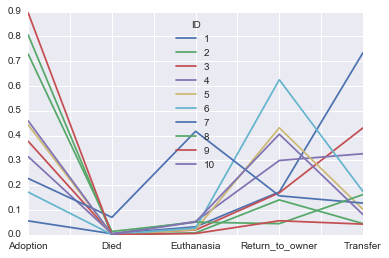

In [104]:
df_result[:10].T.plot()

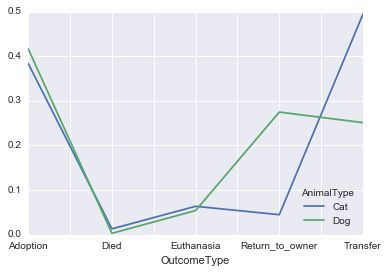

In [105]:
pt2.plot()

## （おまけ）しかし、毎回kaggleに投げるのは問題あり...

In [106]:
# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

In [107]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

cv_scores = cross_val_score(model, X_train, y_train, scoring='log_loss', cv=5, n_jobs=-1)
print"{0:.3f} ({1:.3f})".format(cv_scores.mean(), cv_scores.std())

-0.773 (0.009)


## （おまけ）他のモデルだとどうなるだろう？

In [108]:
# 予測モデルの読み込み

# 分類モデル（他にもいろいろある）
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from xgboost import XGBClassifier # これだけ個別にインストールする必要あり

In [109]:
classifiers = [
    ('lr', LogisticRegression()), 
    ('knn', KNeighborsClassifier()),
    #('linear svc', SVC(kernel="linear")), # データ点が多いと計算に時間がかかるので今回は割愛
    #('rbf svc', SVC(gamma=2)), # データ点が多いと計算に時間がかかるので今回は割愛
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(random_state=42)),
    ('et', ExtraTreesClassifier()),
    ('ab', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('gnb', GaussianNB()),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis()),
    #('xgb', XGBClassifier()) # これだけ個別にインストールする必要があるので今回は割愛
]

In [110]:
warnings.filterwarnings("ignore", category=UserWarning)

import time
results = {}
exec_times = {}

for name, model in classifiers:
    tic = time.time()
    if name in ['linear svc', 'rbf svc']:
        result = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')        
    else:
        result = cross_val_score(model, X_train, y_train, cv=5, scoring='log_loss')
    exec_time = time.time() - tic
    exec_times[name] = exec_time
    results[name] = result
    
    print("{0:.3f} ({1:.3f}): time {2:.2f}s, {3}".format(result.mean(), result.std(), exec_time, name))

-0.867 (0.009): time 3.35s, lr
-4.376 (0.159): time 11.87s, knn
-13.895 (0.242): time 1.05s, dt
-2.210 (0.057): time 1.73s, rf
-2.254 (0.113): time 1.35s, et
-1.547 (0.002): time 4.66s, ab
-0.774 (0.008): time 52.57s, gbc
-4.238 (0.073): time 0.10s, gnb
-0.895 (0.007): time 0.18s, lda
-11.340 (0.279): time 0.17s, qda


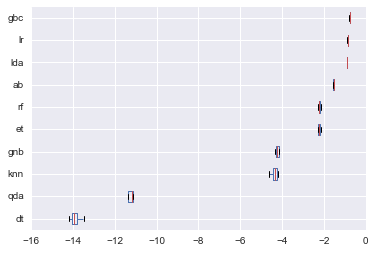

In [111]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 結果の描画を楽にするためpandasのデータフレームに結果を入れる
import pandas as pd

dfr = pd.DataFrame(results)

dfr[dfr.median().sort_values(ascending=True).index].boxplot(vert=False);

## （おまけ）特徴量の重要度を見たいときには？

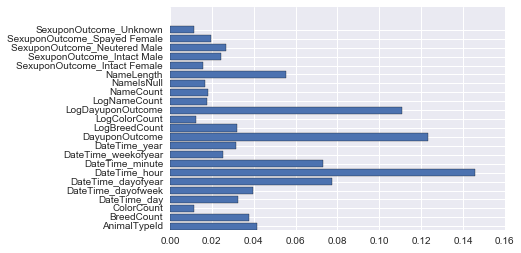

In [112]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
fi = model.feature_importances_
plt.barh(np.arange(len(fi)), fi);
plt.yticks(np.arange(len(fi))+0.4, input_features);

In [113]:
df0 = df[input_features.union(['_data'])]
df0 = df0[df0['_data'] == 'train']

In [114]:
df1 = pd.get_dummies(df_train['OutcomeType'])

In [115]:
df01 = df0.join(df1)

In [116]:
df01.drop('_data', inplace=True, axis=1)

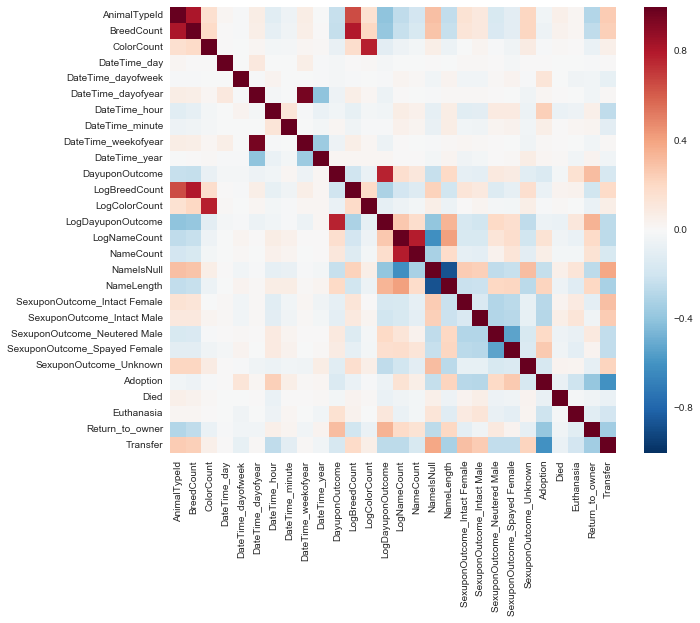

In [117]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df01.corr(), ax=ax)

## （おまけ）ハイパーパラメータの選び方は？

- １次元: validation_curve
- 低次元: GridSearchCV
- 高次元: RandomizedSearchCV

In [118]:
# 交差検証
from sklearn.learning_curve import validation_curve

### GradientBoostingClassifier

In [119]:
param_name = 'max_depth'
#param_name = 'n_estimators'

param_range = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'n_estimators': [10, 20, 40, 80, 160],
    #'n_estimators': [40, 60, 80, 100, 120, 140, 160],
}

fixed_params = {
#    'max_depth': 2
}

train_scores, valid_scores = validation_curve(GradientBoostingClassifier(**fixed_params), 
                                              X_train, y_train, 
                                              scoring='log_loss',
                                              cv = 3,
                                              param_name=param_name, 
                                              param_range=param_range[param_name], 
                                              n_jobs=-1)

In [120]:
train_scores

array([[-0.83960185, -0.84397238, -0.84828766],
       [-0.77251068, -0.77619019, -0.77903378],
       [-0.72310705, -0.72746009, -0.73121859],
       [-0.66015396, -0.66298077, -0.66737468],
       [-0.57018323, -0.57507852, -0.5822217 ],
       [-0.46579424, -0.46257757, -0.47318346],
       [-0.3311318 , -0.33224562, -0.34153161]])

In [121]:
valid_scores

array([[-0.85554951, -0.84649946, -0.84240981],
       [-0.80262696, -0.7921143 , -0.78984488],
       [-0.78107104, -0.77388978, -0.77215346],
       [-0.77308918, -0.7638157 , -0.76008942],
       [-0.76539179, -0.76339537, -0.75574625],
       [-0.76751627, -0.76443491, -0.75760988],
       [-0.77821035, -0.77288166, -0.76636613]])

In [122]:
def plot_validation_curve(train_scores, valid_scores, param_range, semilogx=False):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    if semilogx:
        plot = plt.semilogx
    else:
        plot = plt.plot
    
    plt.title("Validation Curve")
    plt.xlabel("Hyperparameter")
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plot(param_range, valid_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

    print "Best parameter is {}".format(param_range[valid_scores_mean.argmax()])

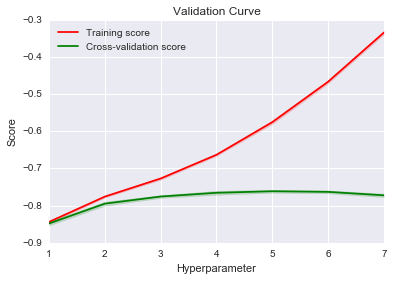

Best parameter is 5


In [123]:
plot_validation_curve(train_scores, valid_scores, 
                      param_range[param_name], semilogx=False);

In [124]:
cv_scores = cross_val_score(GradientBoostingClassifier(max_depth=5, n_estimators=32),
                            X_train, y_train, scoring='log_loss', cv=5, n_jobs=-1)
print"{0:.4f} ({1:.4f})".format(cv_scores.mean(), cv_scores.std())

-0.7821 (0.0084)


### RandomForestClassifier

In [125]:
#param_name = 'max_depth'
param_name = 'n_estimators'

param_range = {
    #'max_depth': np.logspace(0, 8, base=2, num=9),
    'max_depth': [6, 7, 8, 9, 10, 11, 12],
    'n_estimators': np.logspace(2, 11, base=2, num=10).astype(int),
    #'n_estimators': [40, 60, 80, 100, 120, 140, 160],
}

fixed_params = {
    'max_depth': 10
}

train_scores, valid_scores = validation_curve(RandomForestClassifier(**fixed_params), 
                                              X_train, y_train, 
                                              scoring='log_loss',
                                              cv = 3,
                                              param_name=param_name, 
                                              param_range=param_range[param_name], 
                                              n_jobs=-1)

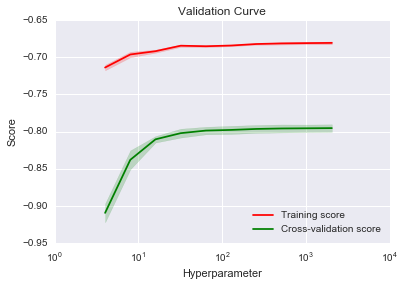

Best parameter is 2048


In [126]:
plot_validation_curve(train_scores, valid_scores, 
                      param_range[param_name], semilogx=True);

In [127]:
cv_scores = cross_val_score(RandomForestClassifier(max_depth=10, n_estimators=2048),
                            X_train, y_train, scoring='log_loss', cv=5, n_jobs=-1)
print"{0:.4f} ({1:.4f})".format(cv_scores.mean(), cv_scores.std())

-0.7927 (0.0067)


## （おまけ）モデルのアベレージング

In [128]:
from sklearn.ensemble import VotingClassifier

In [129]:
estimators = []

# ハイパーパラメータは、モデルごとに交差検証して決める
#estimators.append(('lr', LogisticRegression(C=1)))
estimators.append(('gbc', GradientBoostingClassifier(n_estimators=32, max_depth=5)))
estimators.append(('rf', RandomForestClassifier(n_estimators=2048, max_depth=10)))
#estimators.append(('et', ExtraTreesClassifier(n_estimators=250, max_depth=12)))
#estimators.append(('xgb', XGBClassifier(n_estimators=32, max_depth=6, learning_rate=0.1, 
#                                        colsample_bytree=0.7, reg_alpha=0.0, reg_lambda=1.0, 
#                                        min_child_weight=6, subsample=1.0)))

In [130]:
model = VotingClassifier(estimators=estimators, voting='soft', weights=[1, 1]) 

In [131]:
model.estimators

[('gbc',
  GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                max_depth=5, max_features=None, max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=32,
                presort='auto', random_state=None, subsample=1.0, verbose=0,
                warm_start=False)),
 ('rf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=10, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2048, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

In [132]:
# 各モデルの予測の相関関係をみる。相関関係の薄いモデルをVoting ensembleに入れる

pred_prob = {}
for model_name in model.named_estimators:
    curr_model = model.named_estimators[model_name]
    curr_model.fit(X_train, y_train)
    pred_prob[model_name]  = curr_model.predict_proba(X_test).flatten()#[:, 1]
    
df_pred = pd.DataFrame(pred_prob)
df_pred.corr()

,gbc,rf
gbc,1.000000,0.982009
rf,0.982009,1.000000


In [133]:
results = cross_val_score(model, X_train, y_train, cv=5, scoring='log_loss', n_jobs=-1)
print("({0:.4f}) +/- ({1:.4f})".format(results.mean(), results.std()))

(-0.7813) +/- (0.0075)


In [134]:
# いい感じに全てのモデルのハイパーパラメータが決まったら、全てのモデルをアンサンブル学習
model.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=32,
              presort='...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         voting='soft', weights=[1, 1])

In [135]:
# 予測
y_test_pred = model.predict_proba(X_test)

In [136]:
df_result = pd.DataFrame(y_test_pred, columns=outcome_labels, index=df_test.index)

In [137]:
df_result.to_csv("../output/submission02.csv")